### Example of Using RENI

This notebook contains an example of using a trained RENI. 

This includes loading a pre-trained model from a PyTorch-Lightning <br /> checkpoint and then using the pre-trained decoder as a prior for <br /> environment map inpainting and visualising the output.

Imports and downloading datasets and models:

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from src.utils.utils import get_directions, get_sineweight, get_mask, SelectDevice, download_pretrained_models, sRGB
from src.lightning.RENI_module import RENI
from src.models.RENI import RENIVariationalAutoDecoder
from src.data.datasets import RENIDatasetHDR, RENIDatasetLDR
from src.utils.custom_transforms import transform_builder, UnMinMaxNormlise
from src.utils.loss_functions import RENITestLoss

# download datasets
RENIDatasetHDR('data/RENI_HDR', download=True)
RENIDatasetLDR('data/RENI_LDR', download=True)

# download models
folder_id = '1DkaBxMzCTt5dQyRx14BG9tzCTudY6kKy'
download_pretrained_models(folder_id, 'models')

device = SelectDevice()

Dataset found at: data/RENI_HDR

Dataset found at: data/RENI_LDR

Pretrained models already downloaded
Using GPU idx: 2


### Environment map inpainting. 

Here we use the pre-trained decoder as a prior for inpainting an environment map. <br /> 

To use a pre-trained RENI decoder for your task:

1. Load checkpoint
2. Create a model using checkpoint config hyperparams for all parameters except 'dataset_size' and 'fixed_decoder'
    * a. 'dataset_size' should be set to the required number of latent codes for your task (each latent code represents one spherical signal)
    * b. 'fixed_decoder' should be set to True if using decoder as a prior and only optimising latent codes, e.g. inverse rendering
3. Load checkpoint weights
4. Provide model.parameters() to an optimiser (if 'fixed_decoder' is True only latent codes will be optimised)
5. Run training

#### Note: 

RENI is trained on minmax(log(HDR)) images where minmax is a function of the training dataset,  <br /> the output will likely need to be unnormalised for downstream tasks. This can be done using <br /> src.utils.custom_transforms.UnMinMaxNormlise(), where the minmax argument is obtained <br /> either from the checkpoint config or directly from the RENIDatasetHDR if created using <br /> the same training dataset. 


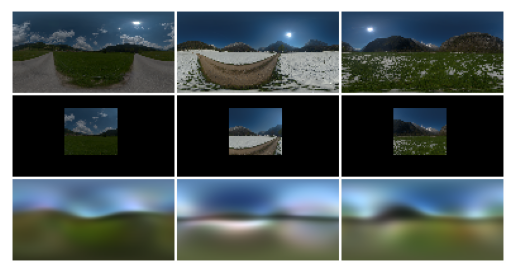

In [3]:
### PLOTTING UTILITY ###
def plot_on_epoch_end(imgs, model_output, mask, H, W, unnormalise):
    imgs = imgs.view(-1, H, W, 3)
    model_output = model_output.view(-1, H, W, 3)
    mask = mask.view(-1, H, W, 3)
    imgs = imgs.permute(0, 3, 1, 2)  # (B, C, H, W)
    model_output = model_output.permute(0, 3, 1, 2)  # (B, C, H, W)
    mask = mask.permute(0, 3, 1, 2)  # (B, C, H, W)
    # unnormalise from minmax(log(HDR)) to HDR
    imgs = unnormalise(imgs)
    model_output = unnormalise(model_output)
    # convert from linear to sRGB
    imgs = sRGB(imgs)
    model_output = sRGB(model_output)
    masked_imgs = imgs * mask

    imgs = torch.concat([imgs, masked_imgs, model_output], dim=0)
    img_grid = make_grid(imgs, nrow=3, pad_value=2)
    img_grid = img_grid.permute(1, 2, 0).cpu().detach().numpy()
    img_grid = (img_grid * 255).astype(np.uint8)
    plt.imshow(img_grid)
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.show()

### LOAD CHECKPOINT ###
chkpt_path = 'models/latent_dim_36_net_5_256_vad_cbc_tanh_hdr/version_0/checkpoints/fit_decoder_epoch=1579.ckpt'
chkpt = torch.load(chkpt_path, map_location=device)
config = chkpt['hyper_parameters']['config']

### DATASET ###
# setup the dataset for your task, here we will just use the RENI_HDR test set
H, W = 64, 128
transform_list = [["resize", [H, W]], ["minmaxnormalise", [-18.0536, 11.4633]]]
transforms = transform_builder(transform_list)
dataset = RENIDatasetHDR('data/RENI_HDR/Test/', transforms=transforms)
subset = torch.utils.data.Subset(dataset, range(3)) # just 3 images for demonstration
dataloader = DataLoader(subset, batch_size=3, shuffle=False)

### MODEL ###
# dataset_size is the number of latent codes required for new the task
dataset_size = len(subset) 
equivariance = config.RENI.EQUIVARIANCE
latent_dim = config.RENI.LATENT_DIMENSION
hidden_layers = config.RENI.HIDDEN_LAYERS
hidden_features = config.RENI.HIDDEN_FEATURES
out_features = config.RENI.OUT_FEATURES
last_layer_linear = config.RENI.LAST_LAYER_LINEAR
output_activation = config.RENI.OUTPUT_ACTIVATION
first_omega_0 = config.RENI.FIRST_OMEGA_0
hidden_omega_0 = config.RENI.HIDDEN_OMEGA_0

# model trained on minmax normalised log(HDR) images where minmax is a function
# of the training dataset. We need to unnormalise the output of the model
# for use in downstream tasks. This can also be obtained from the RENIDatasetHDR dataset.
transforms = config.DATASET[config.DATASET.NAME].TRANSFORMS
minmax = transforms[0][1]
unnormalise = UnMinMaxNormlise(minmax)

# create a model with the same hyperparameters as the checkpoint
# but setting 'dataset_size' to the required number of latent
# codes for your downstream task and 'fixed_decoder' to True
model = RENIVariationalAutoDecoder(dataset_size,
                                   latent_dim,
                                   equivariance,
                                   hidden_features,
                                   hidden_layers,
                                   out_features,
                                   last_layer_linear,
                                   output_activation,
                                   first_omega_0,
                                   hidden_omega_0,
                                   fixed_decoder=True)

model.load_state_dict(chkpt['state_dict'])
model.to(device)

#### OPTIMISER ###
epochs = 100
opt = torch.optim.Adam(model.parameters(), lr=1e-1)

### LOSS ###
# Includes a weighted MSE loss, applying a sineweighting compensation 
# for the irregular sampling of the equirectangular image, a cosine
# similarity loss and a prior loss.
criterion = RENITestLoss(alpha=1e-7, beta=1e-1) 

#### TRAINING ####
directions = get_directions(W) # directions to sample the neural field from (B, H*W, 3)
sineweight = get_sineweight(W) # compensation for the irregular sampling of the equirectangular image (B, H*W, 3)

# In this example we are masking ground truth to test RENI inpainting (B, H*W, 3)
mask = get_mask(W, 'data/Masks/Mask-3.png')
# sineweight scales the loss, so mask is setting all losses outside the crop to zero
sineweight = sineweight * mask

prev_epoch_loss = 0.0
for epoch in range(epochs):
    cur_epoch_loss = 0.0
    for i, batch in enumerate(dataloader):
        imgs, idx = batch
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        imgs = imgs.permute(0, 2, 3, 1)  # (B, C, H, W) -> (B, H, W, C)
        imgs = imgs.view(batch_size, -1, 3)  # (B, H, W, 3) -> (B, H*W, 3)

        D = directions.repeat(batch_size, 1, 1).type_as(imgs)
        S = sineweight.repeat(batch_size, 1, 1).type_as(imgs)
        M = mask.repeat(batch_size, 1, 1).type_as(imgs)

        # get the latent codes representing this batch of training examples
        # each idx in test dataset has a unique latent code
        Z = model.mu[idx, :, :] # This is a VAD model so index parameter 'mu'. AD model would index parameter 'Z'

        # generate model output
        model_output = model(Z, D) # Input -> ((B, latent_dim, 3), (B, H*W, 3)), Output -> (B, H*W, 3)

        # compute loss 
        opt.zero_grad()
        loss, _, _, _ = criterion(model_output, imgs, S, Z)
        cur_epoch_loss += loss.item()
        loss.backward()
        opt.step()
        print(f'Epoch {epoch} Batch {i} Loss {loss.item():.3f} Epoch Loss {prev_epoch_loss:.3f}', end='\r')
        
        cur_epoch_loss = cur_epoch_loss / dataset_size
        prev_epoch_loss = cur_epoch_loss

    if not (epoch) % 20:
      plot_on_epoch_end(imgs, model_output, M, H, W, unnormalise)